# Flujo en 1D.

**Objetivo**. Revisar paso a paso cómo se realiza una simulación de flujo de aguas subterráneas en un dimensión usando el modelo GWF de MODFLOW 6.

<p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/luiggix/RTWMA/blob/main/benchmarks/GWF/01_flujo_1D/01_flujo_1D.ipynb">Flujo en 1D</a> by <b>Luis M. de la Cruz Salas</b>b is licensed under <a href="http://creativecommons.org/licenses/by-sa/4.0/?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a></p> 

In [1]:
# ejecuta esta celda si no se tiene instalado flopy.
!pip install flopy


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python3.12 -m pip install --upgrade pip


# Arquitectura de MODFLOW 6.

## Componentes.

**Véase [1]**.

<img src="../figures/components_mf6.png">

Una simulación típicamente se basa en cuatro componentes:
* **Models**. Un modelo resuelve un proceso hidrológico; por ejemplo, el GWF model, resuelve la ecuación de flujo subterráneo usando el método CVFD.
* **Exchange**. Facilita la comunicación entre dos modelos; por ejemplo, un intercambio GWF-GWF, permite que algunas celdas de un modelo GWF estén hidráulicamente conectadas con celdas del otro modelo GWF.
* **Solutions**. Resuelve uno o más modelos hidrológicos, utiliza métodos iterativos para resolver sistemas no-lineales.
* **Timing**. Controla el paso de tiempo y determina el fin de una simulación.

**<font color='Green'>[1] Langevin, C.D., Hughes, J.D., Provost, A.M., Banta, E.R., Niswonger, R.G., and Panday, Sorab, 2017, Documentation for the MODFLOW 6 Groundwater Flow (GWF) Model: U.S. Geological Survey Techniques and Methods, book 6, chap. A55, 197 p., accessed August 4, 2017. </font>** https://doi.org/10.3133/tm6A55.

## Esquema para GWF.

<img src="../figures/modflow01.png" width=300px hspace="5" vspace="5" style="float: left;"/>

**Tomado de [2]**.

Figura 2. Diagrama esquemático que muestra varias formas comunes en las que los modelos de flujo de agua subterránea (GWF) y transporte de agua subterránea (GWT) se pueden configurar dentro de una simulación. El caso de uso común representado en (A) consiste en un único modelo GWF que se resuelve mediante una solución numérica.

* El modelo GWF descrito en [3] se divide en *paquetes*, como se hacía en versiones anteriores de MODFLOW.
* Un paquete es la parte del modelo que se ocupa de un único aspecto de la simulación.
* Por ejemplo, el paquete *Well* simula el efecto de los pozos y el paquete *River* simula el efecto de los ríos.
* El Modelo GWF contiene muchos paquetes y opciones que el usuario puede o no tener ocasión de utilizar.

**<font color='Green'>[2] Langevin, C. D., Hughes, J. D., Provost, A. M., Russcher, M. J., & Panday, S. (2023). MODFLOW as a configurable Multi‐Model Hydrologic Simulator. Ground Water.</font>** https://doi.org/10.1111/gwat.13351

# Proceso de solución de flujo en 1D.

**Con base en**: 

**<font color='Green'>[3] MODFLOW 6 – Example problems, MODFLOW 6 Development Team, with contributions from Chieh Ying Chen and Mike Toews 02/07/2024.**</font>  **32 MOC3D Problem 1**. (Archivo: `mf6examples.pdf` del directorio `doc` de la distribución de MODFLOW 6).


## Paso 0. Importación de bibliotecas

In [3]:
# Temporal, para agregar las rutas correctas
%run ../../../src/xmf6/ruta_temporal.py
if not(src_path in sys.path[0]):
    sys.path.insert(0, os.path.abspath(a_path + src_path)) 

In [4]:
sys.path

['/Users/luiggi/GitSites/RTWMA/src',
 '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python312.zip',
 '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12',
 '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload',
 '',
 '/Users/luiggi/Library/Python/3.12/lib/python/site-packages',
 '/opt/homebrew/lib/python3.12/site-packages',
 '/opt/homebrew/opt/python-tk@3.12/libexec']

In [6]:
import os, sys     # Intefaces con el sistema operativo.
import numpy as np # Manejo de arreglos numéricos multidimensionales
import matplotlib.pyplot as plt # Graficación

# Biblioteca y módulos de flopy
import flopy
from flopy.plot.styles import styles

# Extras para mf6 y flopy (módulo creado en este proyecto)
import xmf6

## Paso 1. Definición de parámetros del problema.

### Parámetros para la discretización del espacio.

<img src="../figures/mesh_plainview_mf6.png" width=300px hspace="5" vspace="5" style="float: right;"/>
<img src="../figures/mesh_3D_mf6.png" width=300px hspace="5" vspace="5" style="float: right;"/>

* El modelo de malla consiste de 1 capa, 120 columnas y 1 renglón.
* La longitud del renglón es de 12 [cm].
* La longitud de la columna es 0.1 [cm].
* Con la información anterior se calcula el ancho del renglón, DELC, y de las columnas, DELR, que ambos casos debe ser 0.1 $cm$.
* La parte superior (TOP) de la celda es 1.0 [cm] y la parte inferior (BOTTOM) es cero.
* La longitud de la capa es igual a 1.0 [cm], valor que se calcula de |TOP - BOTTOM|.

<img src="../figures/flow_mf6.png">

|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Length of system (rows) |12.0| cm | `mesh.row_length` |
|Number of layers |1| | `mesh.nlay` |
|Number of rows |1| | `mesh.nrow` |
|Number of columns |120| | `mesh.ncol` |
|Column width |0.1| cm | `mesh.delr` |
|Row width |0.1| cm | `mesh.delc`|
|Top of the model |1.0| cm | `mesh.top`|
|Layer bottom elevation (cm) |0| cm | `mesh.bottom` |

In [7]:
mesh = xmf6.MeshDis(
    nrow = 1,    # Number of rows
    ncol = 120,  # Number of columns
    nlay = 1,    # Number of layers
    row_length = 12.0,    # Length of system ($cm$)
    column_length = 0.1,  # Length of system ($cm$)
    top = 1.0,   # Top of the model ($cm$)
    bottom = 0,  # Layer bottom elevation ($cm$)
)

xmf6.nice_print(mesh.get_dict(), 'Space discretization')


Space discretization
------------------------------
          row_length = 12.0      
          col_length = 0.1       
          lay_length = 1.0       
                ncol = 120       
                nrow = 1         
                nlay = 1         
                delr = 0.1       
                delc = 0.1       
                dell = 1.0       
                 top = 1.0       
              bottom = 0.0       


In [8]:
tdis = xmf6.TDis(
    perioddata = ((120, 1.0, 1.0),) # PERLEN, NSTP, TSMULT
)
xmf6.nice_print(tdis, 'Time discretization')


Time discretization
------------------------------
      NPER = 1       
TOTAL TIME = 120.00

PER     PERLEN     NSTP     TSMULT        Dt1
  1     120.00       1.00       1.00   1.20e+02


### Parámetros físicos.

|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---|
|Specific discharge |0.1| cm s$^{-1}$ | `ph_par['specific_discharge']` |
|Hydraulic conductivity |0.01| cm s$^{-1}$ | `ph_par['hydraulic_conductivity']` |
|Source concentration |1.0| unitless | `ph_par['source_concentration']` |


In [9]:
## Model Units
ml_units = {"time" : "seconds",
            "length" : "centimeters"}
xmf6.nice_print(ml_units, 'Units')

## Physical parameters
ph_par = {}
ph_par["specific_discharge"] = 0.1  # Specific discharge ($cm s^{-1}$)
ph_par["hydraulic_conductivity"] = 0.01  # Hydraulic conductivity ($cm s^{-1}$)
ph_par["source_concentration"] = 1.0  # Source concentration (unitless)
xmf6.nice_print(ph_par, 'Physical parameters')


Units
------------------------------
                time = seconds   
              length = centimeters

Physical parameters
------------------------------
  specific_discharge = 0.1       
hydraulic_conductivity = 0.01      
source_concentration = 1.0       


## Paso 2. MODFLOW6 environment y salida.

In [44]:
os_par = dict(
    ws = os.getcwd() + '/output', # Ruta del espacio de trabajo
    mf6_exe = '../../../mf6/bin/Darwin/mf6', # Ejecutable
    flow_name = 'flow', # Nombre de la simulación
)
xmf6.nice_print(os_par, 'MODFLOW 6 environment')

oc_par = dict(
    head_file = f"{os_par['flow_name']}.hds",
    fbudget_file = f"{os_par['flow_name']}.bud"
)
xmf6.nice_print(oc_par, 'Output files')


MODFLOW 6 environment
------------------------------
                  ws = /Users/luiggi/GitSites/RTWMA/benchmarks/GWF/01_flujo_1D/output
             mf6_exe = ../../../mf6/bin/Darwin/mf6
           flow_name = flow      

Output files
------------------------------
           head_file = flow.hds  
        fbudget_file = flow.bud  


## Paso 3. Definición de la simulación (`MFSimulation` object)

**Recordemos que:**

<img src="../figures/modflow01.png" width=300px hspace="5" vspace="5" style="float: left;"/>

In [45]:
sim = flopy.mf6.MFSimulation(
    sim_name = os_par['flow_name'], 
    sim_ws   = os_par['ws'], 
    exe_name = os_par['mf6_exe']
)
print(sim)

sim_name = flow
sim_path = /Users/luiggi/GitSites/RTWMA/benchmarks/GWF/01_flujo_1D/output
exe_name = ../../../mf6/bin/Darwin/mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = flow





## Paso 4. Definición de la discretización temporal (`ModflowTDis` object)

In [46]:
flopy.mf6.ModflowTdis(
    sim, 
    nper = tdis.nper(), 
    perioddata = tdis.perioddata(), 
    time_units = ml_units["time"]
)

package_name = flow.tdis
filename = flow.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = flow

Block options
--------------------
time_units
{internal}
('seconds')


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(120., 1.0, 1.)],
          dtype=[('perlen', '<f8'), ('nstp', 'O'), ('tsmult', '<f8')]))



## Paso 5. Definición de la solución numérica (`ModflowIms` object)

In [47]:
ims = flopy.mf6.ModflowIms(sim)
print(ims)

package_name = ims_-1
filename = flow.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = flow




## Paso 6. Modelo de Flujo (ModflowGwf object)

### GWF: Paquetes

**<font color='Green'>Véase [1].</font>**

<img src="../figures/gwf_mf6.png" width=500px hspace="5" vspace="5" style="float: left;"/>
<img src="../figures/gwf_mf6_pack.png" width=500px hspace="5" vspace="5" style="float: left;"/>

In [48]:
gwf = flopy.mf6.ModflowGwf(
    sim, 
    modelname  = os_par['flow_name'], 
    save_flows = True
)
print(gwf)

name = flow
model_type = gwf6
version = mf6
model_relative_path = .




## Paso 7. Paquete: discretización espacial (`ModflowGwfdis` object)

In [49]:
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    length_units = ml_units["length"],
    nlay = mesh.nlay,
    nrow = mesh.nrow,
    ncol = mesh.ncol,
    delr = mesh.delr,
    delc = mesh.delc,
    top  = mesh.top,
    botm = mesh.bottom,
)
print(dis)

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow

Block options
--------------------
length_units
{internal}
(centimeters)


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(1)

ncol
{internal}
(120)


Block griddata
--------------------
delr
{constant 0.1}

delc
{constant 0.1}

top
{constant 1.0}

botm
{constant 0.0}





## Paso 8. Paquete: condiciones iniciales (`ModflowGwfic` object)



In [50]:
ic = flopy.mf6.ModflowGwfic(
    gwf, 
    strt=1.0 # Initial head
) 
print(ic)

package_name = ic
filename = flow.ic
package_type = ic
model_or_simulation_package = model
model_name = flow

Block griddata
--------------------
strt
{constant 1.0}





## Paso 9. Paquete: propiedades de flujo en los nodos (`ModflowGwfnpd` object)

In [51]:
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge = True,
    save_saturation = True,
    icelltype = 0,
    k = ph_par['hydraulic_conductivity'],
)
print(npf)

package_name = npf
filename = flow.npf
package_type = npf
model_or_simulation_package = model
model_name = flow

Block options
--------------------
save_specific_discharge
{internal}
(True)

save_saturation
{internal}
(True)


Block griddata
--------------------
icelltype
{constant 0}

k
{constant 0.01}





## Paso 10. Paquete: CHD (`ModflowGwfchd` object)

In [52]:
chd = flopy.mf6.ModflowGwfchd(
    gwf, 
    stress_period_data=[[(0, 0, mesh.ncol - 1), 1.0]]  # Node, Constant value
) 
print(chd)

package_name = chd_0
filename = flow.chd
package_type = chd
model_or_simulation_package = model
model_name = flow

Block period
--------------------
stress_period_data
{internal}
(   cellid_layer  cellid_row  cellid_column  head
0             0           0            119   1.0)





## Paso 11. Paquete: Pozos (`ModflowGwfwel` object)

In [53]:
q   = ph_par["specific_discharge"] * mesh.delc * mesh.delr * mesh.top
aux = ph_par["source_concentration"]

wel = flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data = [[(0, 0, 0), q, aux,]],
    pname = "WEL-1",
    auxiliary = ["CONCENTRATION"],
)

print(wel)

package_name = wel-1
filename = flow.wel
package_type = wel
model_or_simulation_package = model
model_name = flow

Block options
--------------------
auxiliary
{internal}
([('auxiliary', 'CONCENTRATION')])


Block period
--------------------
stress_period_data
{internal}
(   cellid_layer  cellid_row  cellid_column      q  CONCENTRATION
0             0           0              0  0.001            1.0)





## Paso 12. Paquete: salida (`ModflowGwfoc` object)

In [54]:
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord   = oc_par['head_file'],
    budget_filerecord = oc_par['fbudget_file'],
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")],
)
print(oc)

package_name = oc
filename = flow.oc
package_type = oc
model_or_simulation_package = model
model_name = flow

Block options
--------------------
budget_filerecord
{internal}
([('flow.bud',)])

head_filerecord
{internal}
([('flow.hds',)])


Block period
--------------------
saverecord
{internal}
([('HEAD', 'ALL', None) ('BUDGET', 'ALL', None)])

printrecord
None




## Paso 13. Escritura de los archivos de entrada para MODFLOW 6

In [55]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...


## Paso 14. Ejecución de la simulación.

In [56]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../mf6/bin/Darwin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 13 2024 17:58:17 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Gov

(True, [])

## Paso 15. Postprocessing

In [38]:
# Obtenemos los resultados de la carga hidráulica
head = flopy.utils.HeadFile(
    os.path.join(os_par['ws'], 
                 oc_par['head_file'])).get_data()

# Obtenemos los resultados del BUDGET
bud  = flopy.utils.CellBudgetFile(
    os.path.join(os_par['ws'], 
                 oc_par['fbudget_file']),
    precision='double'
)
# Obtenemos las velocidades
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [39]:
# Verificamos el tipo y dimensiones de los arreglos donde
# están almacenados la carga hidráulica, el BUDGET, y la velocidad.
print('Head : ', type(head), head.shape)
print('Budget : ', type(bud), bud.shape)
print('spdis : ', type(spdis), spdis.shape)
print('qx : ', type(qx), qx.shape)
print('qy : ', type(qy), qy.shape)
print('qz : ', type(qz), qz.shape)

Head :  <class 'numpy.ndarray'> (1, 1, 120)
Budget :  <class 'flopy.utils.binaryfile.CellBudgetFile'> (np.int32(1), np.int32(1), np.int32(120))
spdis :  <class 'numpy.rec.recarray'> (120,)
qx :  <class 'numpy.ndarray'> (1, 1, 120)
qy :  <class 'numpy.ndarray'> (1, 1, 120)
qz :  <class 'numpy.ndarray'> (1, 1, 120)


In [40]:
print(head.shape, '\n', head)

(1, 1, 120) 
 [[[12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1 12.  11.9 11.8 11.7 11.6
   11.5 11.4 11.3 11.2 11.1 11.  10.9 10.8 10.7 10.6 10.5 10.4 10.3 10.2
   10.1 10.   9.9  9.8  9.7  9.6  9.5  9.4  9.3  9.2  9.1  9.   8.9  8.8
    8.7  8.6  8.5  8.4  8.3  8.2  8.1  8.   7.9  7.8  7.7  7.6  7.5  7.4
    7.3  7.2  7.1  7.   6.9  6.8  6.7  6.6  6.5  6.4  6.3  6.2  6.1  6.
    5.9  5.8  5.7  5.6  5.5  5.4  5.3  5.2  5.1  5.   4.9  4.8  4.7  4.6
    4.5  4.4  4.3  4.2  4.1  4.   3.9  3.8  3.7  3.6  3.5  3.4  3.3  3.2
    3.1  3.   2.9  2.8  2.7  2.6  2.5  2.4  2.3  2.2  2.1  2.   1.9  1.8
    1.7  1.6  1.5  1.4  1.3  1.2  1.1  1. ]]]


In [41]:
print(qx.shape, '\n', qx)

(1, 1, 120) 
 [[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]]


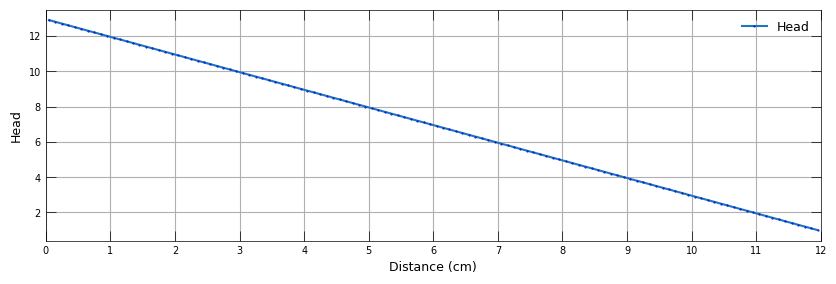

In [42]:
with styles.USGSPlot():
    plt.rcParams['font.family'] = 'DeJavu Sans'
    x, _, _ = mesh.get_coords()
    plt.figure(figsize=(10,3))
    plt.plot(x, head[0, 0], marker=".", ls ="-", mec="blue", mfc="none", markersize="1", label = 'Head')
    plt.xlim(0, 12)
    plt.xticks(ticks=np.linspace(0, mesh.row_length,13))
    plt.xlabel("Distance (cm)")
    plt.ylabel("Head")
    plt.legend()
    plt.grid()
    plt.show()

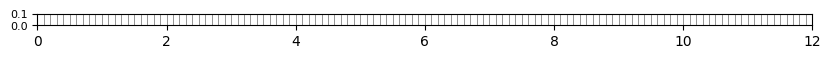

In [43]:
plt.figure(figsize=(10,0.15))
ax = plt.gca()
pmv0 = flopy.plot.PlotMapView(gwf, ax=ax)
pmv0.plot_grid(colors='dimgray', lw=0.5)
plt.yticks(ticks=[0, 0.1],fontsize=8)

plt.show()
